In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.cluster import KMeans
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from tqdm import tqdm


def torus(precision, c, a):
    U = np.linspace(0, 2 * np.pi, precision)
    V = np.linspace(0, 2 * np.pi, precision)
    U, V = np.meshgrid(U, V)
    U = U.flatten()
    V = V.flatten()
    X = (c + a * np.cos(V)) * np.cos(U)
    Y = (c + a * np.cos(V)) * np.sin(U)
    Z = a * np.sin(V)
    return X, Y, Z


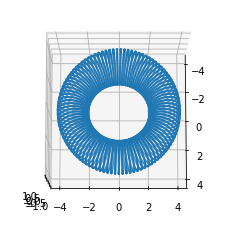

In [2]:
x, y, z = torus(100, 3, 1)
X = np.stack([x, y, z], 1)
# X = np.concatenate(
#     [np.random.rand(300, 3), np.random.rand(300, 3) + 2, np.random.rand(300, 3) - 5, np.random.rand(300, 3) + 20])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*X.T, s=1)
ax.view_init(elev=80., azim=0)
plt.show()

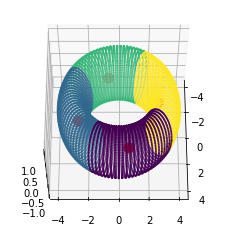

In [3]:
X_torch = torch.from_numpy(X).float()
ds = TensorDataset(X_torch, )
dl = DataLoader(ds, 256, True)

km = KMeans(4)
km.fit(X)
cluster_centers = km.cluster_centers_

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*X.T, s=1, c=km.predict(X))
ax.scatter(*cluster_centers.T, c='red', s=100)
# ax.scatter(*X_torch.T, s=1, alpha=0.1)
ax.view_init(elev=60, azim=0)
plt.show()

In [6]:
class LastModel(nn.Module):
    def __init__(self, cluster_centers):
        super(LastModel, self).__init__()
        self.cluster_centers = nn.Parameter(torch.from_numpy(cluster_centers).float())

    def forward(self, x):
        # batch x
        encoding = x

        distances1 = torch.cdist(encoding, self.cluster_centers, p=2.)
        distances2 = (distances1 ** 2) + 1
        distances3 = 1 / distances2
        q_ij = distances3 / distances3.sum(1)[:, None]
        f_j = q_ij.sum(0)
        p_ij = (q_ij ** 2) / f_j[None, :]
        p_ij = p_ij / p_ij.sum(1)[:, None]

        return p_ij, q_ij, f_j

last_model = LastModel(cluster_centers)
optimizer = optim.Adam(last_model.parameters(), lr=0.005)
loss_fn = nn.KLDivLoss(reduction='batchmean')

pbar = tqdm(range(3000))
for epoch in pbar:
    last_model.train()
    last_model.train()

    p_ij, q_ij, f_j = last_model(X_torch)
    loss1 = loss_fn(q_ij.log(), p_ij)

    optimizer.zero_grad()
    loss1.backward()
    optimizer.step()
    pbar.set_postfix({'loss1': loss1.item()})

100%|██████████| 3000/3000 [00:32<00:00, 92.08it/s, loss1=0.0212] 


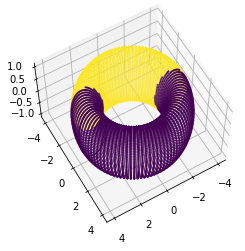

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*X_torch.T, s=1, c=q_ij.argmax(1).numpy())
# ax.scatter(*last_model.cluster_centers.cpu().detach().numpy().T, c='red', s=100)
ax.view_init(elev=60, azim=60)
plt.show()

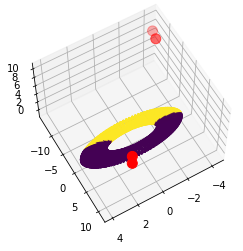

In [10]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*X_torch.T, s=1, c=q_ij.argmax(1).numpy())
ax.scatter(*last_model.cluster_centers.cpu().detach().numpy().T, c='red', s=100)
ax.view_init(elev=60, azim=60)
plt.show()